### Libraries

In [1]:
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt

### Generating *x*

In [2]:
#   Generating random sequence
x = np.random.choice(9, 1000).astype('float32')
print('Sequence shape:', len(x))
print('Last 10 of sequence:', x[:10])

Sequence shape: 1000
Last 10 of sequence: [6. 0. 7. 6. 8. 6. 3. 6. 2. 6.]


### Generating *y(x)*

In [3]:
#   function for creating y(x)
def create_y(x):
    y = np.zeros(len(x), dtype='float')
    y[0] = x[0]
    for i in range(len(x)):
        y[i] = x[0] + x[i]
        if y[i] >= 10:
            y[i] -= 10
    # if need to add some noise
    # y += np.random.randn(y.shape[0])*0.05 
    return y

y = create_y(x)

In [4]:
print('Last 100 of x:', x[:20])
print('Last 100 of y:', y[:20])

Last 100 of x: [6. 0. 7. 6. 8. 6. 3. 6. 2. 6. 5. 7. 0. 6. 5. 8. 2. 0. 0. 6.]
Last 100 of y: [2. 6. 3. 2. 4. 2. 9. 2. 8. 2. 1. 3. 6. 2. 1. 4. 8. 6. 6. 2.]


In [5]:
#    reshaping x (1000, ) -> (1000, 1)
x = x.reshape(-1, 1)
x.shape

(1000, 1)

### Creating dataset for training

In [6]:
#    creating train and test
prop = int(len(x)) - int(len(x)/5) # 80/20

x_train = x[0:prop]
x_test = x[prop:]
y_train = y[0:prop]
y_test = y[prop:]

In [7]:
print('Shape x_train:', x_train.shape)
print('Shape x_test:', x_test.shape)
print('Shape y_train:', y_train.shape)
print('Shape y_test:', y_test.shape)

Shape x_train: (800, 1)
Shape x_test: (200, 1)
Shape y_train: (800,)
Shape y_test: (200,)


In [8]:
#    x,y numpy -> x,y torch
#    creating dataloader
class Sequence(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.len = x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
  
    def __len__(self):
        return self.len

train_set = Sequence(x_train, y_train)
test_set = Sequence(x_test, y_test)

train_loader = DataLoader(train_set, shuffle=True, batch_size=256)

### LSTM

In [9]:
#    LSTM
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        
        self.lstm = nn.LSTM(input_size = 1, 
                            hidden_size = 20, 
                            num_layers = 1, 
                            batch_first = True)
        
        self.fc1 = nn.Linear(in_features = 20, 
                             out_features = 1)

    def forward(self, x):
        output, _status = self.lstm(x)
        output = output[:, -1, :]
        output = self.fc1(torch.relu(output))
        return output

In [10]:
#    function for training
#    we will use same parameters for LSTM, GRU and RNN
seq_dim = x.shape[1]

def train_model(model, train_loader):
    
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=.001)
    epochs = 2000
    
    for i in range(epochs+1):
        for j, data in enumerate(train_loader):
            optimizer.zero_grad()
            y_pred = model(data[:][0].view(-1, seq_dim, 1)).reshape(-1)
            loss = criterion(y_pred, data[:][1])
            loss.backward()
            optimizer.step()
        if i%(epochs/10) == 0:
            print('Epoch: {} , MSE: {:.4f}'.format(i, loss.item()))
     
    return model

In [11]:
#    get trained LSTM-model and create predictions - 'pred_lstm'
lstm = train_model(LSTM(), train_loader)
pred_lstm = lstm(test_set[:][0].view(-1, seq_dim, 1)).view(-1)

Epoch: 0 , MSE: 26.5051
Epoch: 200 , MSE: 6.6262
Epoch: 400 , MSE: 2.5674
Epoch: 600 , MSE: 2.0611
Epoch: 800 , MSE: 2.6430
Epoch: 1000 , MSE: 2.1608
Epoch: 1200 , MSE: 0.9497
Epoch: 1400 , MSE: 0.6767
Epoch: 1600 , MSE: 0.2830
Epoch: 1800 , MSE: 0.1046
Epoch: 2000 , MSE: 0.0268


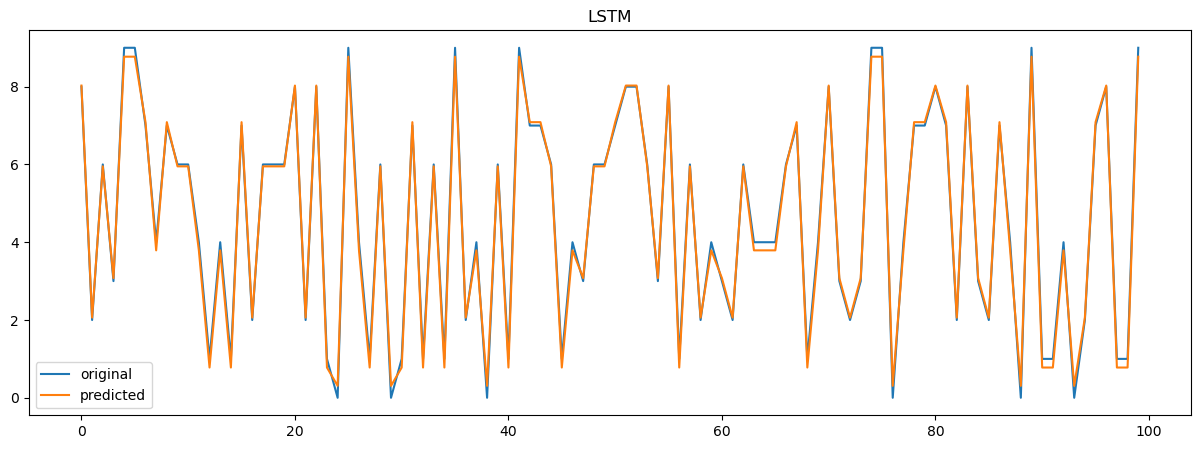

In [12]:
#    def for visual compare predicted and original last 100 values
def model_plot(test_set, test_pred, model):
    orig = test_set[:][1].view(-1)[:100]
    pred = test_pred.detach().numpy()[:100]
    plt.figure(figsize=(15,5))
    plt.plot(orig, label='original')
    plt.plot(pred, label='predicted')
    plt.legend()
    plt.title(model.__class__.__name__)
    plt.show();

model_plot(test_set, pred_lstm, LSTM())

### GRU

In [13]:
#    GRU
class GRU(nn.Module):
    def __init__(self):
        super(GRU,self).__init__()
        
        self.gru = nn.GRU(input_size=1, 
                            hidden_size=20, 
                            num_layers=1, 
                            batch_first=True)
        
        self.fc1 = nn.Linear(in_features=20, 
                             out_features=1)

    def forward(self, x):
        output, _status = self.gru(x)
        output = output[:,-1,:]
        output = self.fc1(torch.relu(output))
        return output

In [14]:
#    get trained GRU-model and create predictions - 'pred_gru'
gru = train_model(GRU(), train_loader)
pred_gru = gru(test_set[:][0].view(-1, seq_dim, 1)).view(-1)

Epoch: 0 , MSE: 26.7389
Epoch: 200 , MSE: 5.5609
Epoch: 400 , MSE: 4.1761
Epoch: 600 , MSE: 2.3660
Epoch: 800 , MSE: 2.5208
Epoch: 1000 , MSE: 1.1885
Epoch: 1200 , MSE: 1.0394
Epoch: 1400 , MSE: 0.6345
Epoch: 1600 , MSE: 0.1379
Epoch: 1800 , MSE: 0.0395
Epoch: 2000 , MSE: 0.0096


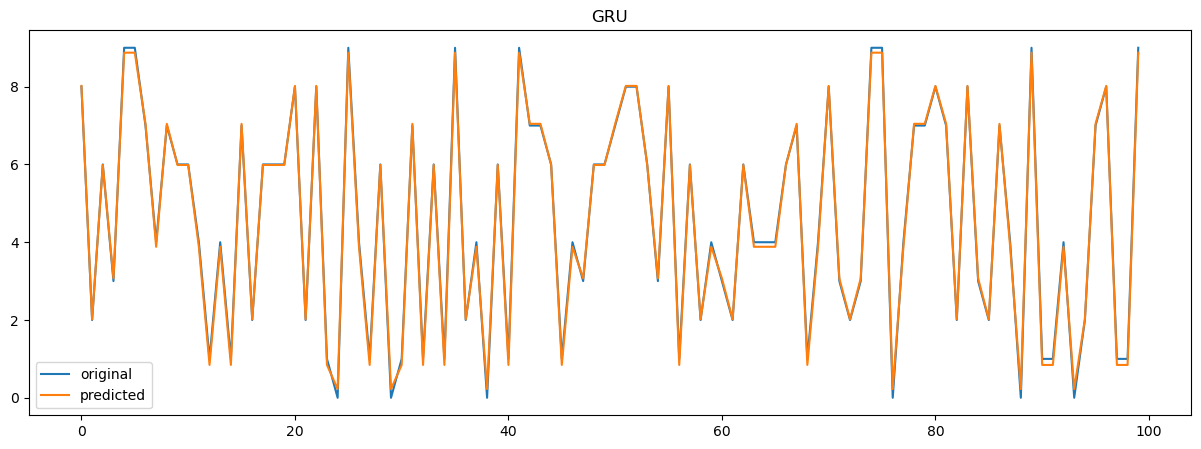

In [15]:
model_plot(test_set, pred_gru, GRU())

### RNN

In [16]:
#    RNN
class RNN(nn.Module):
    def __init__(self):
        super(RNN,self).__init__()
        
        self.rnn = nn.RNN(input_size=1, 
                            hidden_size=20, 
                            num_layers=1, 
                            batch_first=True)
        
        self.fc1 = nn.Linear(in_features=20, 
                             out_features=1)

    def forward(self, x):
        output, _status = self.rnn(x)
        output = output[:,-1,:]
        output = self.fc1(torch.relu(output))
        return output

In [17]:
#    get trained RNN-model and create predictions - 'pred_rnn'
rnn = train_model(RNN(), train_loader)
pred_rnn = rnn(test_set[:][0].view(-1, seq_dim, 1)).view(-1)

Epoch: 0 , MSE: 24.2632
Epoch: 200 , MSE: 9.2936
Epoch: 400 , MSE: 7.8161
Epoch: 600 , MSE: 4.6958
Epoch: 800 , MSE: 5.5939
Epoch: 1000 , MSE: 2.2672
Epoch: 1200 , MSE: 3.1983
Epoch: 1400 , MSE: 2.2024
Epoch: 1600 , MSE: 1.9814
Epoch: 1800 , MSE: 1.9603
Epoch: 2000 , MSE: 1.8103


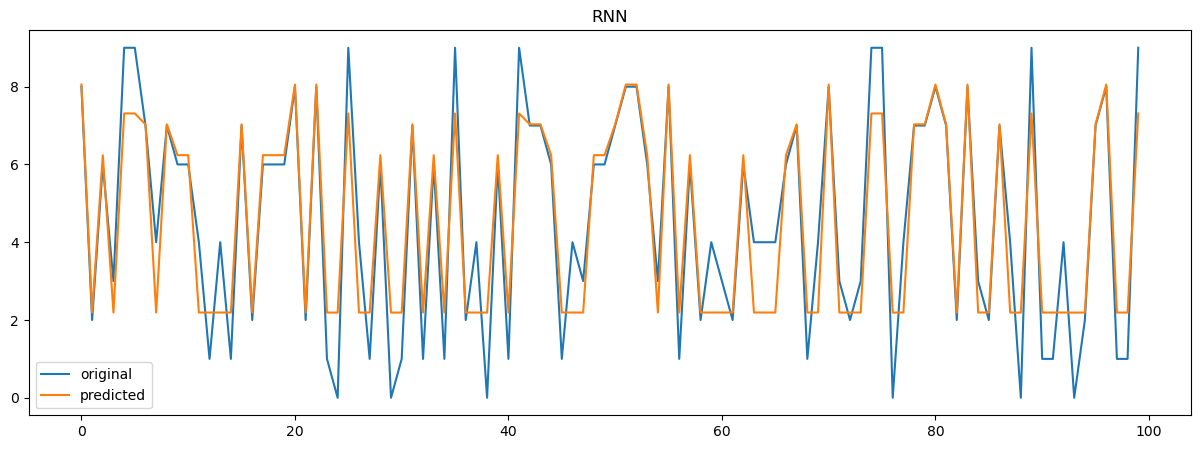

In [18]:
model_plot(test_set, pred_rnn, RNN())

### Сonclusion

LSTM and GRU cells show good results and require fewer training cycles compared to simple RNN.